In [ ]:
import scipy.io #initializes libraries

import time
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
mat = scipy.io.loadmat('/content/Oxford_Battery_Degradation_Dataset_1.mat') #reads dataset
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [ ]:
input_data = [
    [[], []],  # cell 1, [0, 1, 2, ... 82], [730, 729, ... value for q, ... , 530]
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []]
]
print(input_data)


input_data1 = [
    [[], []],  # cell 1, [0, 1, 2, ... 82], [730, 729, ... value for q, ... , 530]
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []]
]

CELL_SIZE = [83, 78, 82, 52, 49, 51, 82, 82] # number of the cycles for each cell

[[[], []], [[], []], [[], []], [[], []], [[], []], [[], []], [[], []], [[], []]]


In [ ]:
for i in range(0, 8): #breaks down dataset to return the values that we need
    cell_num = "Cell{}".format(i + 1)
    for j in range(0, CELL_SIZE[i]):
        cyc_num = "cyc{:04d}".format(j * 100) # if j=47, cyc_num = "cyc4700"; if j=1, cyc_num = "cyc0100"
        try:
            curr = mat[cell_num][0][cyc_num][0][0]["C1ch"][0][0]['q'][0][-1][0]
        except ValueError:
            curr = float("NaN")
        input_data[i][0].append(j)
        input_data[i][1].append(curr)

In [ ]:
for i in range(0,8):
      cell_num1 = "Cell{}".format(i + 1)
    for j in range(0, CELL_SIZE[i]):
        cyc_num1 = "cyc{:04d}".format(j * 100) # if j=47, cyc_num = "cyc4700"; if j=1, cyc_num = "cyc0100"
        try:
            curr1 = mat[cell_num1][0][cyc_num1][0][0]["C1dc"][0][0]['q'][0][-1][0]
        except ValueError:
            curr1 = float("NaN")
        input_data1[i][0].append(j)
        input_data1[i][1].append(curr1)

In [ ]:
train_x = []
train_y = []
#test_x is a 2d dataset
test_x = [
    [],
    [],
    [],
    []
]
#test_y is a 2d dataset
test_y = [
    [],
    [],
    [],
    []
]

In [ ]:
for i in range(0, 8):

    df_input = pd.DataFrame(input_data[i]).transpose()
    df_input = df_input.rename(columns={0: "cycle", 1: "q_value"})
    df_input['interpolate_time'] = df_input['q_value'].interpolate(option='time') #time interpolate preprocessing of cells 1 to 8
    df_input['soh'] = df_input['interpolate_time'] / 740

    print(df_input.head())

    df_input = df_input.drop("cycle", axis=1)
    df_input = df_input.drop("q_value", axis=1)
    df_input = df_input.drop("interpolate_time", axis=1)

    # normalisation
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df_input.values)
    label_sc.fit(df_input.iloc[:, 0].values.reshape(-1, 1)) #MinMaxScaler preprocessing of cells 1 to 8

    # windowing of time series
    lookback = 10 #data windowing value
    inputs = np.zeros((len(data) - lookback, lookback, df_input.shape[1]))
    labels = np.zeros(len(data) - lookback)

    for j in range(lookback, len(data)):
        inputs[j - lookback] = data[j - lookback:j]
        labels[j - lookback] = data[j, 0]
    inputs = inputs.reshape(-1, lookback, df_input.shape[1])
    labels = labels.reshape(-1, 1)

    if (i < 4):
        if len(train_x) == 0:
            train_x = inputs[:]
            train_y = labels[:]
        else:
            train_x = np.concatenate((train_x, inputs[:]))
            train_y = np.concatenate((train_y, labels[:]))
    else:
        test_x[i - 4] = inputs
        test_y[i - 4] = labels

   cycle     q_value  interpolate_time       soh
0    0.0  724.120891        724.120891  0.978542
1    1.0  714.535043        714.535043  0.965588
2    2.0  709.854346        709.854346  0.959263
3    3.0  707.039349        707.039349  0.955459
4    4.0  702.234286        702.234286  0.948965
   cycle     q_value  interpolate_time       soh
0    0.0  718.741298        718.741298  0.971272
1    1.0  709.568107        709.568107  0.958876
2    2.0  704.905816        704.905816  0.952575
3    3.0  702.345615        702.345615  0.949116
4    4.0  697.136847        697.136847  0.942077
   cycle     q_value  interpolate_time       soh
0    0.0  718.763140        718.763140  0.971302
1    1.0  709.773753        709.773753  0.959154
2    2.0  705.500350        705.500350  0.953379
3    3.0  703.179716        703.179716  0.950243
4    4.0  698.679304        698.679304  0.944161
   cycle     q_value  interpolate_time       soh
0    0.0  721.116484        721.116484  0.974482
1    1.0  712.067932

In [ ]:
np.array(train_x).shape

(255, 10, 1)

In [ ]:
np.array(train_y).shape

(255, 1)

In [ ]:
np.array(test_x[0]).shape # test_x = [[Cell5], [Cell6], [Cell7], [Cell8]]

(39, 10, 1)

In [ ]:
np.array(test_y[0]).shape

(39, 1)

In [ ]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
print(is_cuda)
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

False


In [ ]:
##            GRUNET Class     ####
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [ ]:
####          LSTMNet         ######
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [ ]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=100, model_type="GRU"):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    print("----------------------------------------")
    print("The", model_type, "has the layers as: ")
    print(model)
    print("----------------------------------------")

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter,
                                                                                       len(train_loader),
                                                                                       avg_loss / counter))

        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss / len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time - start_time)))
        epoch_times.append(current_time - start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [ ]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))

    print("Evaluation Time: {}".format(str(time.process_time() - start_time)))
    MAE = 0
    RMSE = 0
    for i in range(len(outputs)):
        MAE += np.mean(abs(outputs[i] - targets[i])) / len(outputs)
        RMSE += np.mean((outputs[i] - targets[i]) ** 2) / len(outputs)
    RMSE = math.sqrt(RMSE)
    print("MAE: {}".format(MAE))
    print("RMSE: {}".format(RMSE))
    return outputs, targets, MAE, RMSE

In [ ]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")
lstm_model = train(train_loader, lr, model_type="LSTM")

----------------------------------------
The GRU has the layers as: 
GRUNet(
  (gru): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)
----------------------------------------
Starting Training of GRU model
Epoch 1......Step: 1/7....... Average Loss for Epoch: 0.15811440348625183
Epoch 1......Step: 2/7....... Average Loss for Epoch: 0.11768186464905739
Epoch 1......Step: 3/7....... Average Loss for Epoch: 0.10328404108683269
Epoch 1......Step: 4/7....... Average Loss for Epoch: 0.08877001143991947
Epoch 1......Step: 5/7....... Average Loss for Epoch: 0.08270012512803078
Epoch 1......Step: 6/7....... Average Loss for Epoch: 0.07991030501822631
Epoch 1......Step: 7/7....... Average Loss for Epoch: 0.07484555191227368
Epoch 1/100 Done, Total Loss: 0.07484555191227368
Total Time Elapsed: 0.40647712000000524 seconds
Epoch 2......Step: 1/7....... Average Loss for Epoch: 0.036648351699113846
Epoch 2......Ste

In [ ]:
torch.save(gru_model.state_dict(), "/content/gru_model.pt")
torch.save(lstm_model.state_dict(), "/content/lstm_model.pt")

GRU Evaluation for Cell 5
Evaluation Time: 0.02852239099999565
MAE: 0.003748996558746501
RMSE: 0.003976327910364675


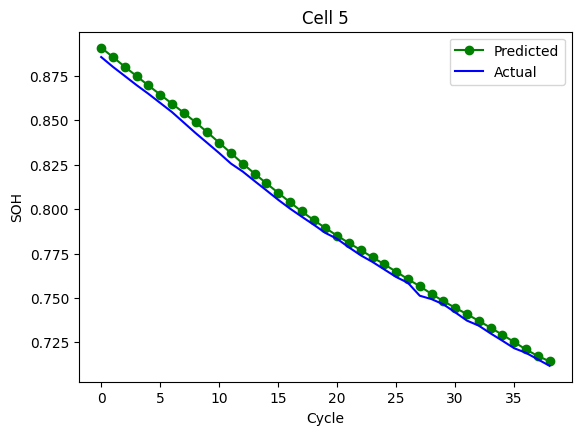

GRU Evaluation for Cell 6
Evaluation Time: 0.02630353999998647
MAE: 0.0038661365203802914
RMSE: 0.005564809624238887


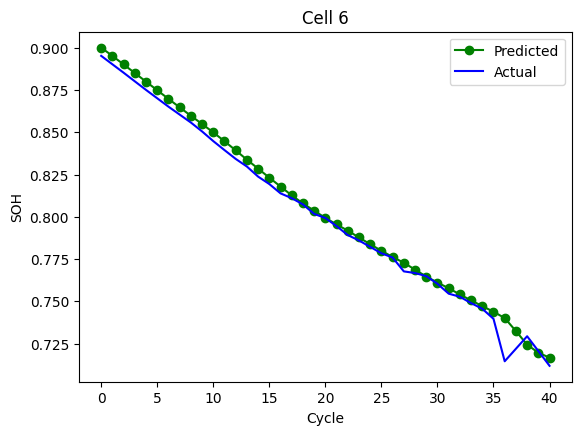

GRU Evaluation for Cell 7
Evaluation Time: 0.03702654599999278
MAE: 0.0014113797270473248
RMSE: 0.0016397846941206137


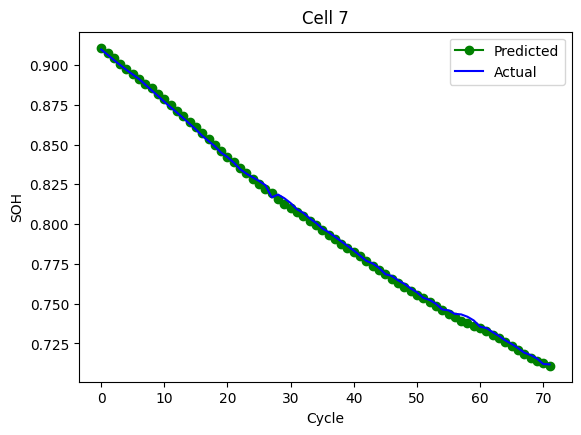

GRU Evaluation for Cell 8
Evaluation Time: 0.036464979999976777
MAE: 0.001293536696604465
RMSE: 0.001641422417719124


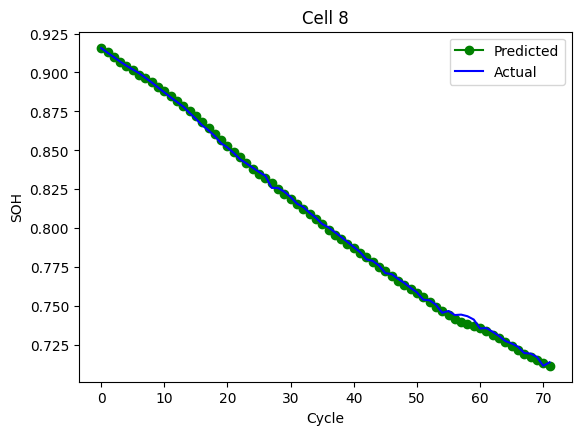

In [ ]:
for i in range(0, 4): #plot both graphs
    print("GRU Evaluation for Cell {}".format(i + 5))
    gru_outputs, targets, gru_MAE, gru_RMSE = evaluate(gru_model, test_x[i], test_y[i], label_sc)
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
    plt.plot(targets[0][-100:], color="b", label="Actual")
    plt.xlabel('Cycle')
    plt.ylabel('SOH')
    plt.title("Cell {}".format(i + 5))
    plt.legend()
    plt.show()

# MAE and RMSE
# predicted curve
# performance, numerical results

LSTM Evaluation for Cell 5
Evaluation Time: 0.0211332000000084
MAE: 0.009391940980270158
RMSE: 0.00955715731660222


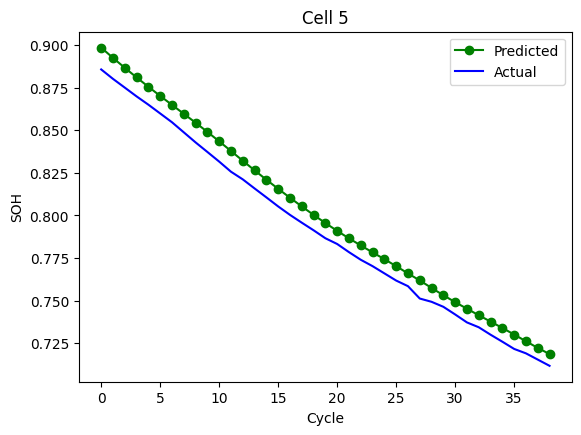

LSTM Evaluation for Cell 6
Evaluation Time: 0.029953444999989642
MAE: 0.008929862754510026
RMSE: 0.009823550132054694


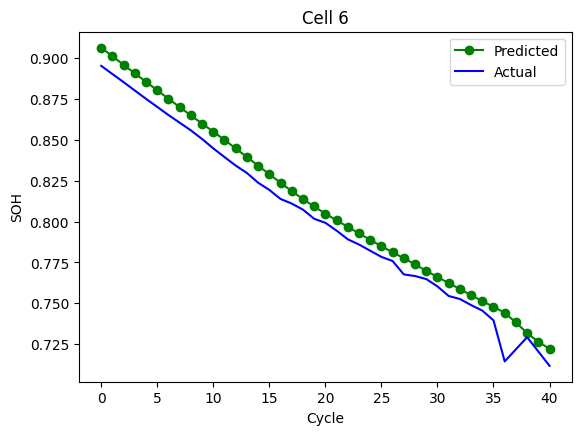

LSTM Evaluation for Cell 7
Evaluation Time: 0.0430849629999841
MAE: 0.002620836196774475
RMSE: 0.002914279748162675


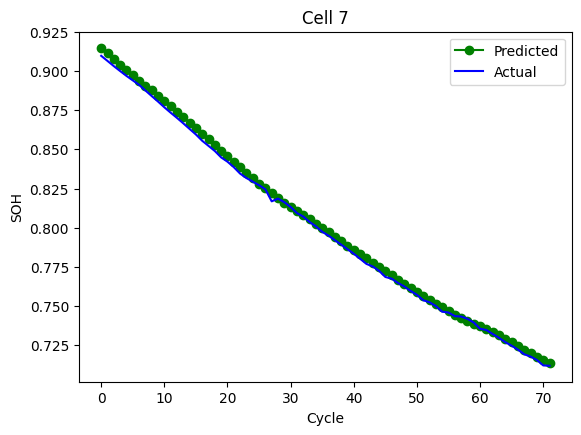

LSTM Evaluation for Cell 8
Evaluation Time: 0.05433841999999345
MAE: 0.0028494341656691846
RMSE: 0.0031079640914324193


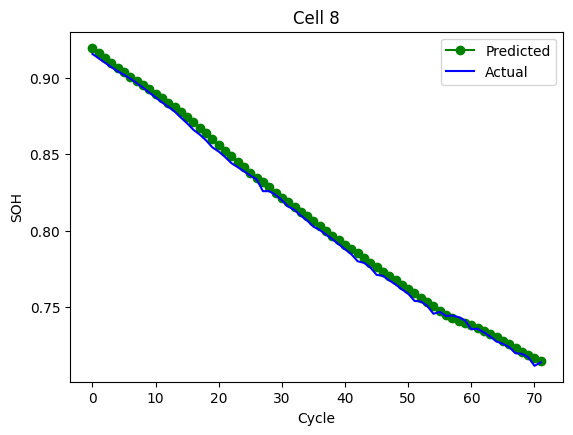

In [ ]:
for i in range(0, 4):
    print("LSTM Evaluation for Cell {}".format(i + 5))
    lstm_outputs, targets, lstm_MAE, lstm_RMSE = evaluate(lstm_model, test_x[i], test_y[i], label_sc)
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(lstm_outputs[0][-100:], "-o", color="g", label="Predicted")
    plt.plot(targets[0][-100:], color="b", label="Actual")
    plt.xlabel('Cycle')
    plt.ylabel('SOH')
    plt.title("Cell {}".format(i + 5))
    plt.legend()
    plt.show()